In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [17, 12]
from IPython.display import Audio

In [2]:
import numpy as np
import torch
from scipy.signal import find_peaks

In [3]:
from rt_ddsp.synths import Harmonic
from rt_ddsp import core

We generate a signal using `Harmonic`, take the FFT of it, and compare its FFT peaks with the control values. Also takes into consideration filtlering above Nyquist frequency.

In [4]:
from typing import Tuple, Any, Dict

def get_frequency_peaks(signal: torch.Tensor,
                        sample_rate: int,
                        height: float) -> Tuple[torch.Tensor, torch.Tensor]:
    spectrum = np.abs(np.fft.rfft(signal.numpy())) / (len(signal) / 2)
    peaks, _ = find_peaks(spectrum, height=height)
    peak_freqs = np.fft.rfftfreq(len(signal), 1 / sample_rate)[peaks]
    peak_amps = spectrum[peaks]

    plt.plot(spectrum)
    plt.plot(peaks, spectrum[peaks], "x")
    plt.plot(np.zeros_like(spectrum), "--", color="gray")
    plt.show()
    
    return core.torch_float32(peak_freqs), core.torch_float32(peak_amps)


def get_batch_frequency_peaks(signal: torch.Tensor,
                              sample_rate: int,
                              height: float) -> Tuple[torch.Tensor, torch.Tensor]:
    peak_freqs = []
    peak_amps = []
    for s in signal:
        pf, pa = get_frequency_peaks(s, sample_rate, height)
        peak_freqs.append(pf)
        peak_amps.append(pa)

    return torch.stack(peak_freqs), torch.stack(peak_amps)


def static_sawtooth_features(fundamental_frequency: float,
                             base_amplitude: float,
                             n_harmonics: int = 30,
                             n_frames: int = 1000,
                             batch_size: int = 3) -> Dict[str, torch.Tensor]:
    amp = torch.zeros(batch_size, n_frames, 1) + base_amplitude

    harmonic_distribution = 1 / torch.arange(1, n_harmonics + 1)
    # harmonic_distribution = torch.ones(n_harmonics)  # impulse features
    harmonic_distribution.view(1, 1, n_harmonics).repeat(batch_size, n_frames, 1)

    f0_hz = torch.zeros(batch_size, n_frames, 1) + fundamental_frequency

    return {
        'amplitudes': amp,
        'harmonic_distribution': harmonic_distribution,
        'f0_hz': f0_hz
    }

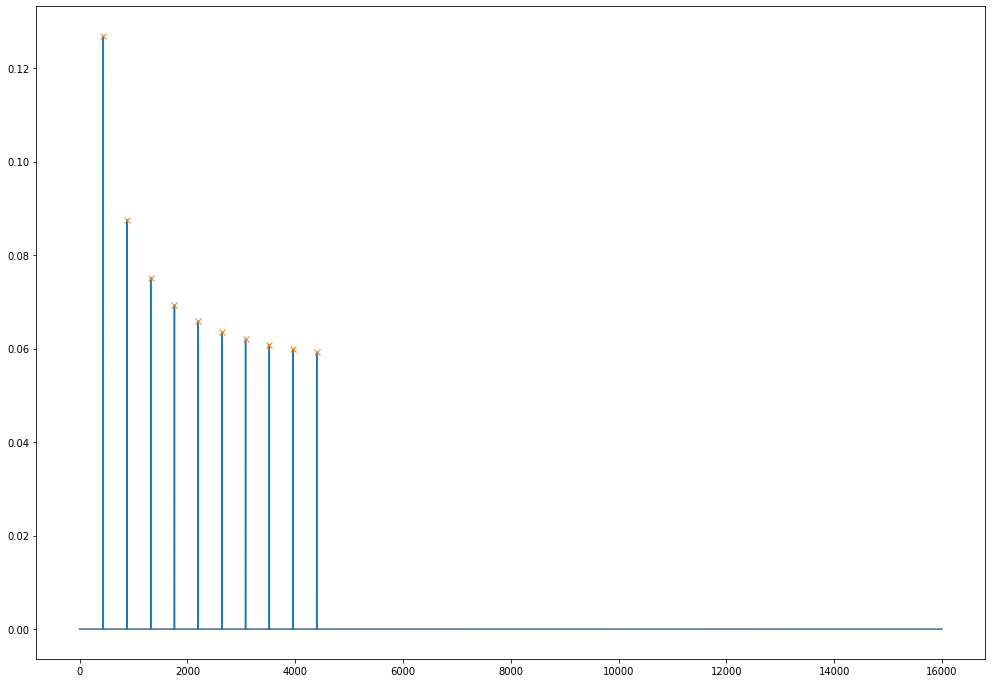

In [5]:
n_harmonics=10
batch_size=1
f0=220.
amp=0.6

n_frames = 500

harmonic_synth = Harmonic(16000*2, 16000)
sample_rate = harmonic_synth.sample_rate
controls = static_sawtooth_features(f0, amp, n_harmonics, n_frames, batch_size)
signal = harmonic_synth(**controls)
modified_controls = harmonic_synth.get_controls(**controls)

shit_mask = modified_controls['harmonic_distribution'][0, 0] > 0.
height = (modified_controls['harmonic_distribution'][:, :, shit_mask] * modified_controls[
    'amplitudes']).numpy().min() * 0.95
peak_freqs, peak_amps = get_batch_frequency_peaks(
    signal, sample_rate, height)

expected_peak_freqs = f0 * torch.arange(1, n_harmonics + 1)
expected_peak_freqs = expected_peak_freqs.repeat(batch_size, 1)

dist_amps = modified_controls['harmonic_distribution'][:, 0, :]
base_amps = modified_controls['amplitudes'][:, 0, :]
expected_peak_amps = (dist_amps * base_amps)

# filter above nyquist
# TODO: currently we are assuming the whole batch has the same f0, harmonic, and amp values
#       otherwise peak_freqs and expected_peak_frames would have different sizes
#       later handle this by zero padding the smaller one or something like that
mask = expected_peak_freqs[0].lt(sample_rate / 2)
expected_peak_amps = expected_peak_amps[:, mask]
expected_peak_freqs = expected_peak_freqs[:, mask]

np.testing.assert_array_almost_equal(peak_freqs, expected_peak_freqs, decimal=5)
np.testing.assert_array_almost_equal(peak_amps, expected_peak_amps, decimal=5)

In [6]:
Audio(signal, rate=16000, normalize=False)

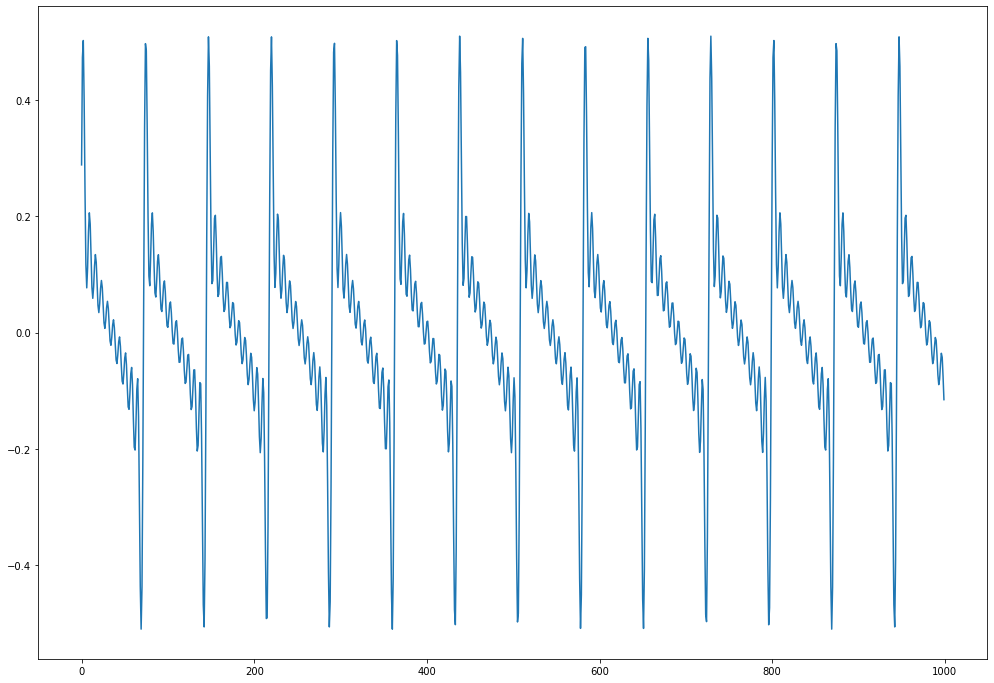

In [7]:
plt.plot(signal[0, :1000])